In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img

import cv2
import itertools
import pathlib
import warnings
from PIL import Image
from random import randint
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix


from tensorflow import keras
from keras import layers
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

from distutils.dir_util import copy_tree, remove_tree

import os
print(os.listdir("/content/drive/MyDrive/FINAL YEAR PROJECT/INPUT DATASET 02"))

print("TensorFlow Version:", tf.__version__)

['MODERATED DEMENTED', 'MILD DEMENTED', 'NON DEMENTED', 'VERY MILD DEMENTED']
TensorFlow Version: 2.9.2


In [6]:
import tensorflow as tf
from efficientnet.tfkeras import EfficientNetB0

# Load the pre-trained EfficientNetV2B0 model
model = EfficientNetB0(weights='imagenet')

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Use the model for prediction
model.predict(input_data)


ModuleNotFoundError: ignored

In [ ]:
!pip install split-folders
import splitfolders

input_file = '/content/drive/MyDrive/FINAL YEAR PROJECT/INPUT DATASET 02'
output_file = '/content/drive/MyDrive/FINAL YEAR PROJECT/INPUT DATASET SPLITTED 05'

splitfolders.ratio(input_file, output=output_file, seed=1345, ratio=(.70, 0.15,0.15), group_prefix=None)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 6400 files [03:54, 27.26 files/s] 


In [ ]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
"/content/drive/MyDrive/FINAL YEAR PROJECT/INPUT DATASET SPLITTED 05/train",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
"/content/drive/MyDrive/FINAL YEAR PROJECT/INPUT DATASET SPLITTED 05/test",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
"/content/drive/MyDrive/FINAL YEAR PROJECT/INPUT DATASET SPLITTED 05/val",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

Found 4479 files belonging to 4 classes.
Found 962 files belonging to 4 classes.
Found 959 files belonging to 4 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)
train_ds

['MILD DEMENTED', 'MODERATED DEMENTED', 'NON DEMENTED', 'VERY MILD DEMENTED']


<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

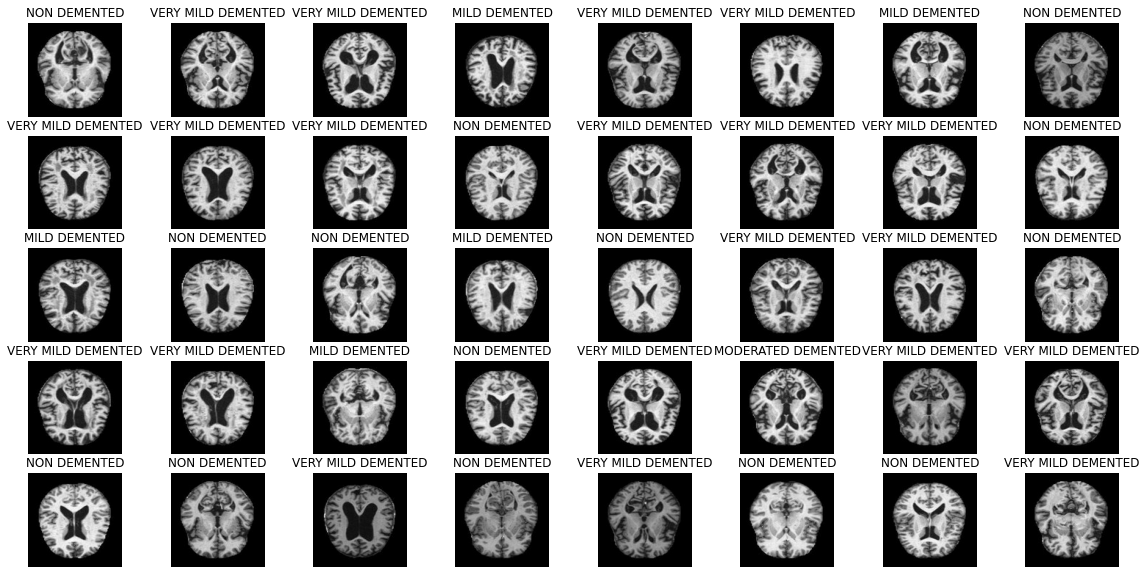

In [ ]:
plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1):
    for i in range(40):
        ax = plt.subplot(5, 8, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<function matplotlib.pyplot.show(*args, **kw)>

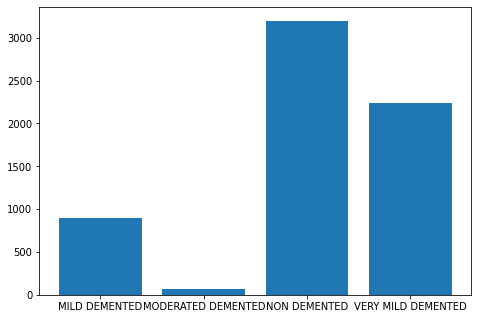

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
size = [896,64,3200,2240]
ax.bar(class_names,size)
plt.show

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)))
model.add(keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


model.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.20))

model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(64,"relu"))
model.add(keras.layers.Dense(4,"softmax"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "Adam",metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0

In [ ]:
hist = model.fit(train_ds,validation_data=val_ds,epochs=100, batch_size=32, verbose=1)

Epoch 1/100
70/70 [==============================] - 16s 93ms/step - loss: 1.3139 - accuracy: 0.4820 - val_loss: 1.0560 - val_accuracy: 0.5005
Epoch 2/100
70/70 [==============================] - 6s 81ms/step - loss: 0.9828 - accuracy: 0.5316 - val_loss: 0.9546 - val_accuracy: 0.5381
Epoch 3/100
70/70 [==============================] - 6s 82ms/step - loss: 0.9199 - accuracy: 0.5626 - val_loss: 0.9058 - val_accuracy: 0.5620
Epoch 4/100
70/70 [==============================] - 6s 83ms/step - loss: 0.8784 - accuracy: 0.5832 - val_loss: 0.8893 - val_accuracy: 0.5746
Epoch 5/100
70/70 [==============================] - 6s 83ms/step - loss: 0.8165 - accuracy: 0.6341 - val_loss: 0.8441 - val_accuracy: 0.5923
Epoch 6/100
70/70 [==============================] - 6s 83ms/step - loss: 0.7744 - accuracy: 0.6497 - val_loss: 0.8098 - val_accuracy: 0.6204
Epoch 7/100
70/70 [==============================] - 6s 82ms/step - loss: 0.7066 - accuracy: 0.6926 - val_loss: 0.6584 - val_accuracy: 0.7185
Epoch

In [ ]:
get_ac = hist.history['accuracy']
get_los = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

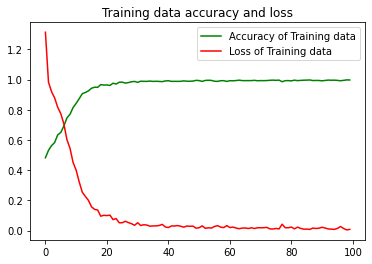

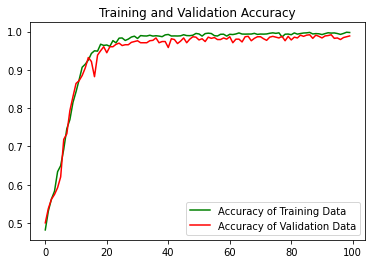

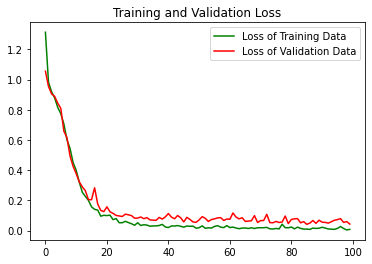

<Figure size 432x288 with 0 Axes>

In [ ]:
epochs = range(len(get_ac))
plt.plot(epochs, get_ac, 'g', label='Accuracy of Training data')
plt.plot(epochs, get_los, 'r', label='Loss of Training data')
plt.title('Training data accuracy and loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_ac, 'g', label='Accuracy of Training Data')
plt.plot(epochs, val_acc, 'r', label='Accuracy of Validation Data')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_los, 'g', label='Loss of Training Data')
plt.plot(epochs, val_loss, 'r', label='Loss of Validation Data')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_ds)

16/16 [==============================] - 1s 36ms/step - loss: 0.0189 - accuracy: 0.9927


1/1 [==============================] - 0s 14ms/step


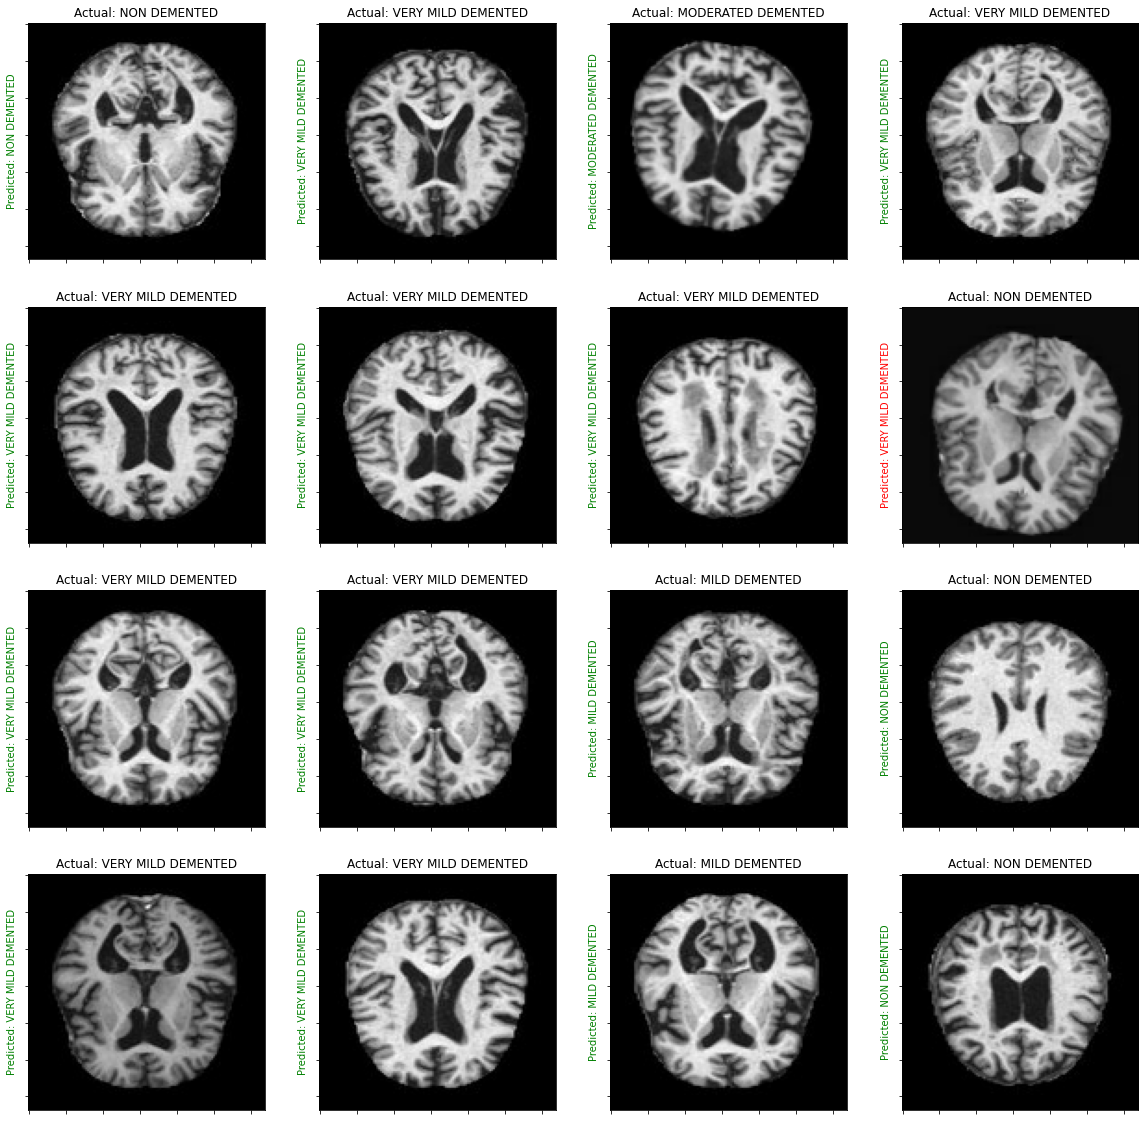

In [ ]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'green'})
            
        else:
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'red'})
        plt.gca().axes.yaxis.set_ticklabels([])        
        plt.gca().axes.xaxis.set_ticklabels([])